In [2]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Load the data

We decided to work on an already existing dataset to get our images samples : [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Although it is a dataset used for Classification, our intent in downloading it was to easily get image samples.

In [3]:
# Resize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
])

# Load the CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:08<00:00, 20.4MB/s]


In [ ]:
def plot_images(images, titles, cols=3):
    num_images = len(images)
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
    plt.figure(figsize=(15, 5 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        # Remove the batch dimension, move to CPU, and detach from the computation graph
        image_to_plot = image.squeeze().cpu().detach()
        # Normalize the image to the range [0, 1]
        image_to_plot = (image_to_plot - image_to_plot.min()) / (image_to_plot.max() - image_to_plot.min())
        # Ensure the image has three dimensions (height, width, channels)
        if image_to_plot.dim() == 3:
            image_to_plot = image_to_plot.permute(1, 2, 0)
        plt.imshow(image_to_plot.numpy())
        plt.title(title)
        plt.axis('off')
    plt.show()

In [12]:
plot_images(train_dataset[0], '')

<Figure size 1500x500 with 0 Axes>

We need to get get noised smaples of the images. For this, we define the NoisyCIFAR10 Class that takes our image samples and adds gaussian noise with $ \sigma = 0.1 $. We will use these images for our training.



In [4]:
def add_gaussian_noise(image, noise_sigma=0.1):
    """Add Gaussian noise to an image tensor."""
    noisy_image = image + noise_sigma * torch.randn_like(image)
    return torch.clip(noisy_image, 0, 1)

class NoisyCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, noise_sigma=0.1):
        super(NoisyCIFAR10, self).__init__(root=root, train=train, download=download, transform=transform)
        self.noise_sigma = noise_sigma

    def __getitem__(self, index):
        image, label = super(NoisyCIFAR10, self).__getitem__(index)

        # Add Gaussian noise to the image
        noisy_image = add_gaussian_noise(image, self.noise_sigma)

        return noisy_image, image  # Return both noisy and clean images

Epoch 1/10, Loss: 0.0021627184469252825
Epoch 2/10, Loss: 0.001901470124721527
Epoch 3/10, Loss: 0.001954878680408001
Epoch 4/10, Loss: 0.0017162652220577002
Epoch 5/10, Loss: 0.0017283245688304305
Epoch 6/10, Loss: 0.0017296744044870138
Epoch 7/10, Loss: 0.0019595250487327576
Epoch 8/10, Loss: 0.0016155163757503033
Epoch 9/10, Loss: 0.001408775569871068
Epoch 10/10, Loss: 0.0014669212978333235


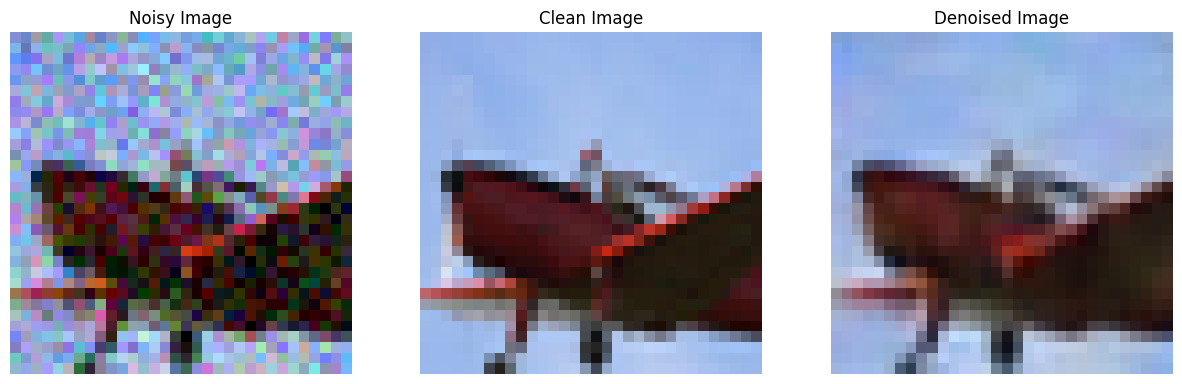

In [28]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training function
def train_score_network(model, dataloader, epochs=200, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for noisy_image, clean_image in dataloader:
            noisy_image, clean_image = noisy_image.cuda(), clean_image.cuda()
            optimizer.zero_grad()
            output = model(noisy_image)

            # Resize the output to match the input dimensions
            output = F.interpolate(output, size=clean_image.shape[2:])

            loss = criterion(output, clean_image)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Denoising function
def denoise_image(noisy_image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        noisy_image = noisy_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        denoised_image = model(noisy_image)
        denoised_image = F.interpolate(denoised_image, size=noisy_image.shape[2:])
    return denoised_image.cpu()

# Example usage
if __name__ == "__main__":
    # Load the noisy CIFAR-10 training dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = NoisyCIFAR10(root='./data', train=True, download=True, transform=transform, noise_sigma=0.1)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize the score network
    model_normal = UNet().cuda()

    # Train the score network
    train_score_network(model_normal, train_loader, epochs=10)

    # Load a noisy image for denoising
    noisy_image, clean_image = next(iter(train_loader))
    noisy_image = noisy_image[0].unsqueeze(0)  # Take the first image in the batch

    # Denoise the image
    denoised_image = denoise_image(noisy_image, model_normal)

    # Plot the images
    plot_images([noisy_image.cpu(), clean_image[0].cpu(), denoised_image.cpu()], ["Noisy Image", "Clean Image", "Denoised Image"])

MSE Loss: 0.07244239002466202


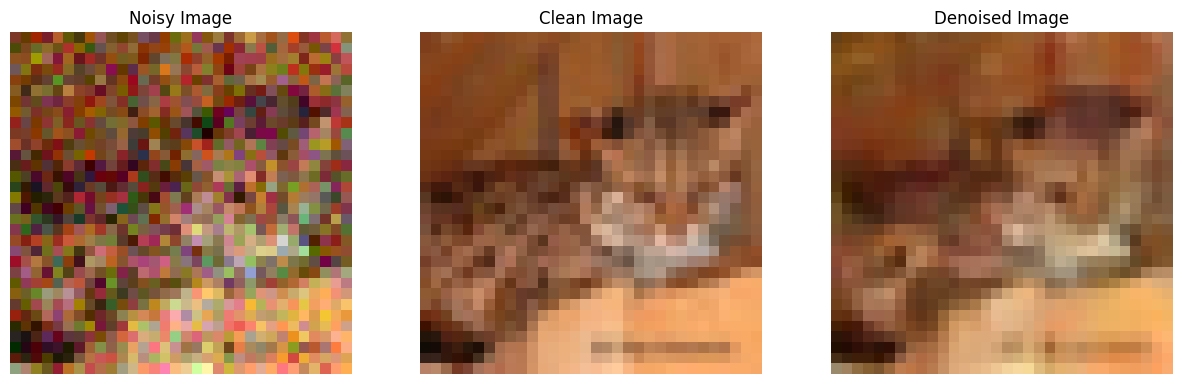

In [15]:
noisy_image_test, clean_image_test = next(iter(train_loader))

denoised_image_test = denoise_image(noisy_image, model_normal)


denoised_image_np = denoised_image_test.cpu().numpy()
clean_image_np = clean_image_test[0].unsqueeze(0).cpu().numpy()


# Calculate MSE using NumPy
mse_loss = np.mean((denoised_image_np - clean_image_np) ** 2)

# Print the MSE loss
print(f"MSE Loss: {mse_loss}")

plot_images([noisy_image.cpu(), clean_image[0].cpu(), denoised_image.cpu()], ["Noisy Image", "Clean Image", "Denoised Image"])

Epoch 1/50, Loss: 0.005060215946286917
Epoch 2/50, Loss: 0.0024175175931304693
Epoch 3/50, Loss: 0.0023118825629353523
Epoch 4/50, Loss: 0.00225340505130589
Epoch 5/50, Loss: 0.0021687927655875683
Epoch 6/50, Loss: 0.0021944206673651934
Epoch 7/50, Loss: 0.0021282732486724854
Epoch 8/50, Loss: 0.002101973397657275
Epoch 9/50, Loss: 0.0020080842077732086
Epoch 10/50, Loss: 0.001992595149204135
Epoch 11/50, Loss: 0.001969383331015706
Epoch 12/50, Loss: 0.0019314308883622289
Epoch 13/50, Loss: 0.0019308665068820119
Epoch 14/50, Loss: 0.0018570910906419158
Epoch 15/50, Loss: 0.0019211864564567804
Epoch 16/50, Loss: 0.001797231612727046
Epoch 17/50, Loss: 0.001826871302910149
Epoch 18/50, Loss: 0.001759425736963749
Epoch 19/50, Loss: 0.0016970623983070254
Epoch 20/50, Loss: 0.0017657598946243525
Epoch 21/50, Loss: 0.0017562519060447812
Epoch 22/50, Loss: 0.0017159952549263835
Epoch 23/50, Loss: 0.0017302891938015819
Epoch 24/50, Loss: 0.0017958374228328466
Epoch 25/50, Loss: 0.0016941151116

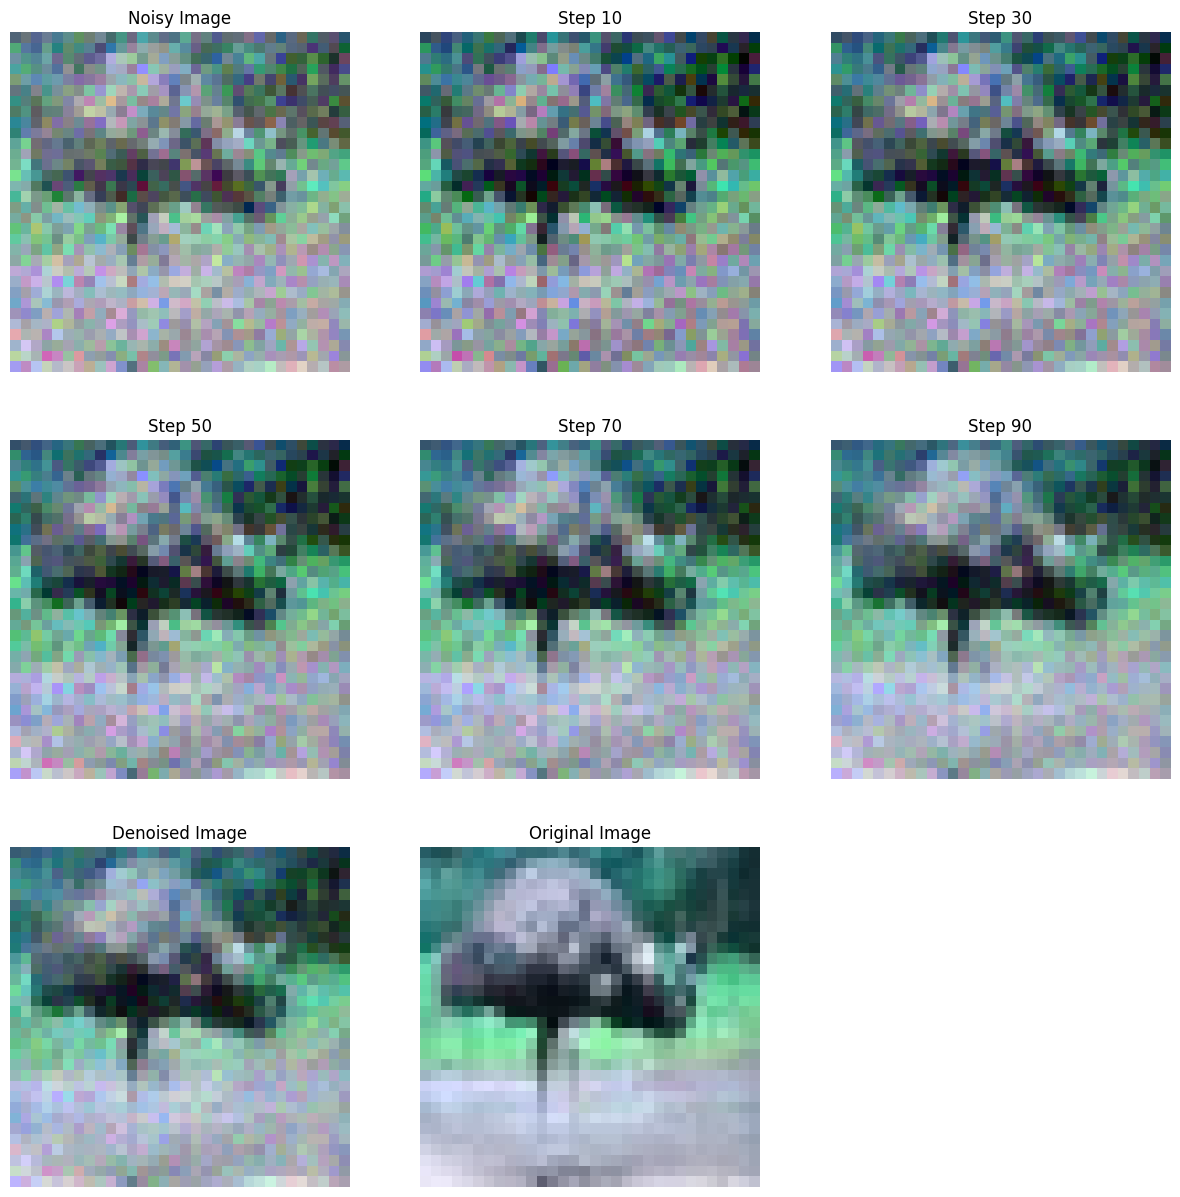

In [32]:
# Define the Score Network
class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Training function for the Score Network
def train_score_network(model, dataloader, epochs=200, lr=0.0001, noise_sigma=0.1):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for clean_image, _ in dataloader:
            clean_image = clean_image.cuda()
            noise = torch.randn_like(clean_image) * noise_sigma
            noisy_image = clean_image + noise

            optimizer.zero_grad()
            score = model(noisy_image)
            loss = criterion(score * noise_sigma**2 + noisy_image, clean_image)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Denoising function using Langevin dynamics with intermediate steps
def denoise_image_score_based(noisy_image, model, noise_sigma=0.1, num_steps=100, step_size=0.001, intermediate_steps=None):
    model.eval()
    with torch.no_grad():
        x = noisy_image.clone()
        intermediate_images = []
        for step in range(num_steps):
            noise = torch.randn_like(x) * noise_sigma
            score = model(x)
            x = x + step_size * score + noise * (2 * step_size)**0.5
            x = torch.clamp(x, 0, 1)  # Ensure the image stays in the range [0, 1]

            # Store intermediate images if specified
            if intermediate_steps and step in intermediate_steps:
                intermediate_images.append(x.clone().cpu())

        return x, intermediate_images

# Example usage
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = ScoreNetwork().cuda()
    train_score_network(model, train_loader, epochs=50)

    original_image, _ = next(iter(train_loader))
    original_image = original_image[0].unsqueeze(0).cuda()
    noisy_image = original_image + torch.randn_like(original_image) * 0.1

    # Specify intermediate steps to visualize
    intermediate_steps = [10, 30, 50, 70, 90]
    denoised_image, intermediate_images = denoise_image_score_based(noisy_image, model, step_size=0.0001, intermediate_steps=intermediate_steps)

    # Calculate MSE
    # mse_value = calculate_mse(denoised_image, original_image)
    # print(f"MSE between denoised and original image: {mse_value}")

    # Plot the images
    images_to_plot = [noisy_image.cpu()] + intermediate_images + [denoised_image.cpu()] + [original_image.cpu()]
    titles = ["Noisy Image"] + [f"Step {step}" for step in intermediate_steps] + ["Denoised Image"] + ["Original Image"]
    plot_images(images_to_plot, titles)


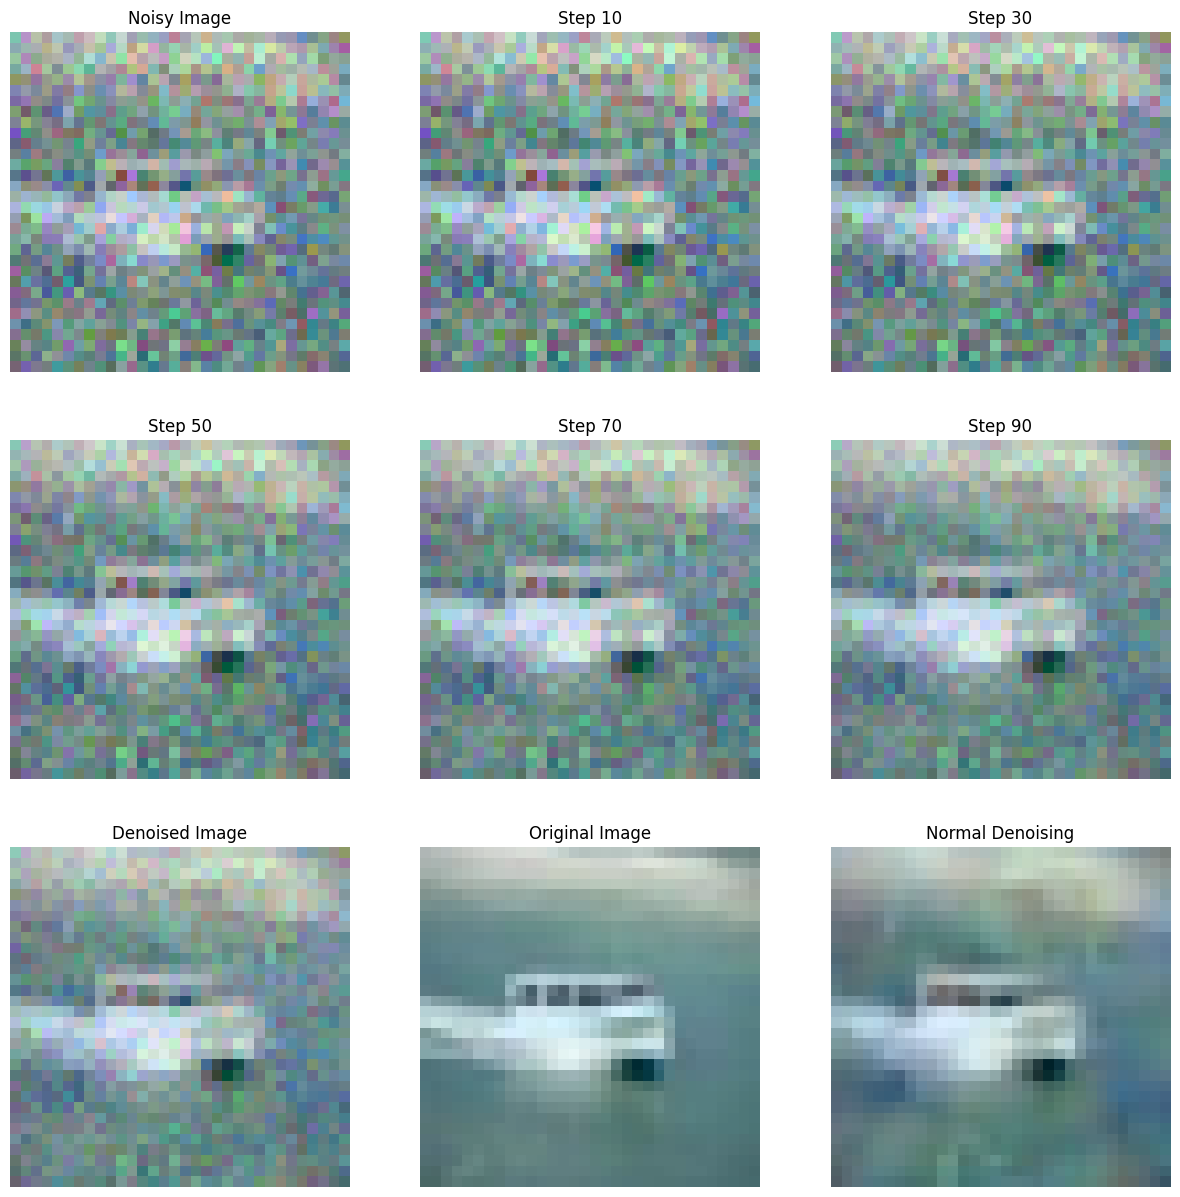

In [33]:
original_image, _ = next(iter(train_loader))
original_image = original_image[0].unsqueeze(0).cuda()
noisy_image = original_image + torch.randn_like(original_image) * 0.1

# Specify intermediate steps to visualize
intermediate_steps = [10, 30, 50, 70, 90]
denoised_image, intermediate_images = denoise_image_score_based(noisy_image, model, step_size=0.0001, intermediate_steps=intermediate_steps)

# Calculate MSE
# mse_value = calculate_mse(denoised_image, original_image)
# print(f"MSE between denoised and original image: {mse_value}")

denoised_image_test = denoise_image(noisy_image, model_normal)

# Plot the images
images_to_plot = [noisy_image.cpu()] + intermediate_images + [denoised_image.cpu()] + [original_image.cpu()] + [denoised_image_test.cpu()]
titles = ["Noisy Image"] + [f"Step {step}" for step in intermediate_steps] + ["Denoised Image"] + ["Original Image"] + ["Normal Denoising"]
plot_images(images_to_plot, titles)

In [21]:
denoised_image_np, intermediate_images = denoise_image_score_based(noisy_image_test, model, step_size=0.0001, intermediate_steps=intermediate_steps)
denoised_image_np = denoised_image_np.cpu().numpy()
clean_image_np = clean_image_test[0].unsqueeze(0).cpu().numpy()


# Calculate MSE using NumPy
mse_loss = np.mean((denoised_image_np - clean_image_np) ** 2)

# Print the MSE loss
print(f"MSE Loss: {mse_loss}")

plot_images([noisy_image.cpu(), clean_image[0].cpu(), denoised_image.cpu()], ["Noisy Image", "Clean Image", "Denoised Image"])

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## Impact of the step size